In [1]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
from PIL import Image
from tqdm.auto import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
from torchvision.transforms import ToPILImage
import random
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import datetime
import pytz
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import re
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from openslide import OpenSlide
import openslide

## 파라미터 설정

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:

# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")

현재 디바이스는 mps:0 입니다.


In [4]:
CFG = {
    'IMG_SIZE':512,
    'BATCH_SIZE': 64,
    'SEED':41,
    'MEAN' : [0.485, 0.456, 0.406],
    'STD'  : [0.229, 0.224, 0.225],
    'pth' : "git_ignore/pthfile/2023_06_07/train:20X_test:20X_epoch:50_(2023_06_07_03:24_PM).pth"
}

In [5]:
kst = pytz.timezone('Asia/Seoul')
current_datetime = datetime.datetime.now(kst)
day = current_datetime.strftime("%Y_%m_%d")
hour = current_datetime.strftime("%I:%M_%p")
print(day, hour)

2023_06_14 11:57_AM


In [6]:
# # server path
# output_path = f"/data/output/{day}"
# figure_path = f"{output_path}/figure"
# test_data_path = f"data/PDA_svs_img"


In [7]:
# server path
output_path = f"git_ignore/output/{day}"
figure_path = f"{output_path}/figure"
test_data_path = f"git_ignore/PDA_svs_img"


In [8]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 불러오기

In [9]:
test_path_list = glob.glob(f"{test_data_path}/*")
test_svs = test_path_list[0]

In [10]:
slide = (OpenSlide(test_svs))
print(f'level count          :: {slide.level_count}')
print(f'image size per level :: {slide.level_dimensions}')
print(f'level 0 MPP          :: {slide.properties.get("openslide.mpp-x")}')

level count          :: 3
image size per level :: ((15935, 12960), (3983, 3240), (1991, 1620))
level 0 MPP          :: 0.49419999999999997


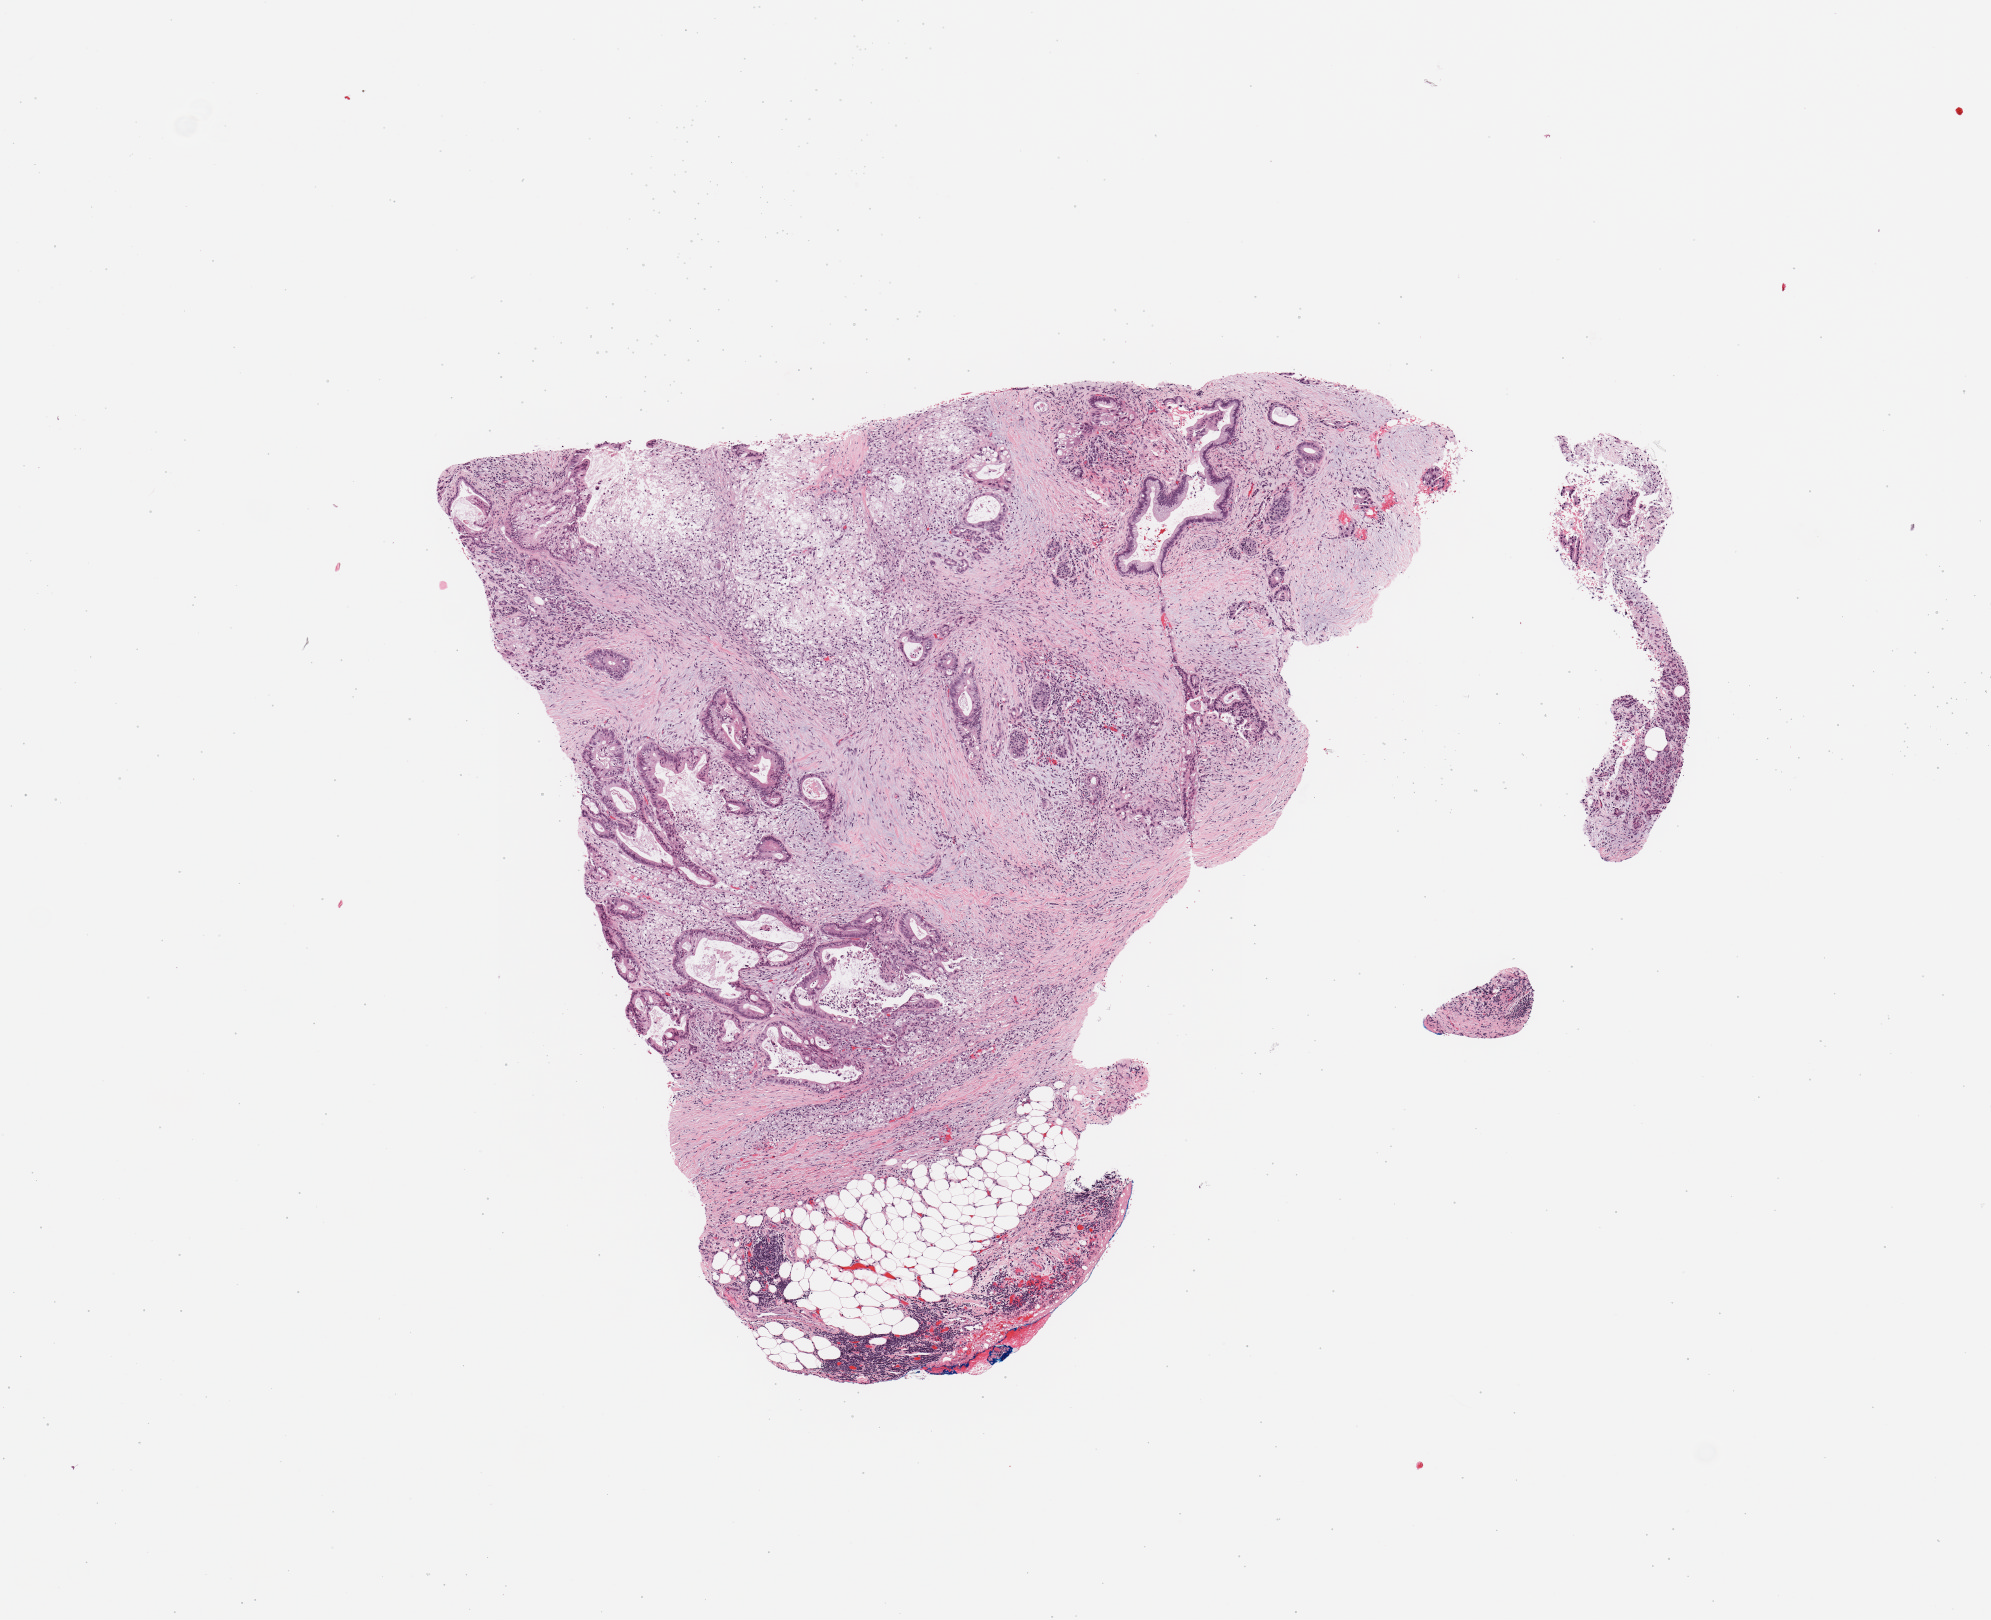

In [11]:
slide.read_region((0,0), 2, slide.level_dimensions[2])

## 패치 나누기

In [12]:
# vis_level 0 (20x magnification)
slide_arr = np.array(slide.read_region((0,0), 0, slide.level_dimensions[0]).convert("RGB"))

In [13]:
slide_x_size = slide_arr.shape[1] # WSI의 열 차원 크기 
slide_y_size = slide_arr.shape[0] # WSI의 행 차원 크기

# 추출할 패치 사이즈
step_x = CFG["IMG_SIZE"] # X축(열방향) 사이즈 
step_y = CFG["IMG_SIZE"] # Y축(행방향) 사이즈 

# 각 축 별 추출할 패치 개수
num_x = int(slide_x_size/step_x) # X축 방향 개수
num_y = int(slide_y_size/step_y) # Y축 방향 개수
print(f"총 패치 데이터의 개수: {num_x*num_y}")

# WSI를 패치로 나누어 리스트에 저장
img_split_list = []

for y_index in range(0, num_y): 
    for x_index in range(0, num_x):
        temp_image = slide_arr[step_y * y_index : step_y * (y_index + 1), step_x * x_index : step_x * (x_index + 1)] 
        img_split_list.append(temp_image)

총 패치 데이터의 개수: 775


## 패치 데이터 Load

In [14]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_split_list, transform = None):
        self.image = img_split_list
        self.transform = transform

    def __len__(self):
        return len(self.image)  # 데이터셋 길이
    
    def __getitem__(self, i):
        image = self.image[i]
        transformed = self.transform(image = image)
        image = transformed["image"]
        return image

In [15]:
test_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        ToTensorV2()
])

In [16]:
# 테스트 데이터
test_set = CustomDataset(img_split_list= img_split_list,
                         transform = test_transform)

In [17]:
test_loader = DataLoader(test_set, batch_size = CFG["BATCH_SIZE"])

In [18]:
print(f"test_data : {len(test_set)}")

test_data : 775


## Test

In [19]:
# Modeling
class ResUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResUNet, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder.conv1(x)
        x1 = self.encoder.bn1(x1)
        x1 = self.encoder.relu(x1)
        x1 = self.encoder.maxpool(x1)

        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)
        x = self.relu(self.conv1(x))

        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)
        x = self.relu(self.conv2(x))

        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)
        x = self.relu(self.conv3(x))

        x = self.conv4(x)

        # Resize to 512x512
        x = nn.functional.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)

        return x

In [20]:
# 학습 파라미터
model = ResUNet(num_classes=1).to(device)
model = nn.DataParallel(model)

/Users/moksu/miniforge3/envs/lion/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/moksu/miniforge3/envs/lion/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
model.load_state_dict(torch.load(CFG['pth'], map_location='mps'))

<All keys matched successfully>

In [22]:
# Test
def Test(model, test_loader, device):
    model.eval()
    label_list = []
    with torch.no_grad():
        for img in tqdm(test_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            output = pred.cpu().detach().numpy().astype(int)
            label_list.extend(output)
        return label_list

In [23]:
label_list = Test(model, test_loader, device)

  0%|          | 0/13 [00:00<?, ?it/s]

## 패치 하나로 합치기

In [24]:
def apply_mask_image(image, label, alpha=0.3):
    """픽셀별로 mask 적용하기

    Args:
        image: 각 픽셀 값
        color: 클래스 별 masking color 값을 행으로 하는 행렬 (8x3)
        alpha: 투명도 [0,1]

    Returns:
        image에 mask 입힌 이미지 반환
    """
    
    new_image = (1 - alpha) * image + alpha * label
    
    return new_image

In [25]:
def image_crop_list_to_total_image(image_array_list, step_x, step_y, step_num_x, step_num_y):
    # masking한 패치 이미지를 다시 전체 슬라이드 이미지로 합치기

    if len(image_array_list) != step_num_y * step_num_x:
        raise Exception('length of image_Array_list is not same to step_num_y X step_num_X')

    # 전체 슬라이드 이미지와 같은 크기의 영행렬 생성
    out_image_array = np.zeros((step_y * step_num_y, step_x * step_num_x, 3), dtype = np.uint8)

    # masking 된 패치 이미지로 이루어진 전체 슬라이드 이미지 생성
    cnt = 0
    for y_index in range(0, step_num_y):
        for x_index in range(0, step_num_x):
            out_image_array[step_y * y_index : step_y * (y_index + 1), step_x * x_index : step_x * (x_index + 1)] = image_array_list[cnt]
            cnt += 1

    return out_image_array

In [26]:
def convert_grayscale_to_rgb(grayscale_image):
    # Convert grayscale image to RGB
    rgb_image = np.repeat(grayscale_image[:, :, np.newaxis], 3, axis=2)
    return rgb_image

In [27]:
# 마스크 이미지 3채널로 변환 후 색상 입히기
label_3 = []
for i in label_list:
    label_3.append(convert_grayscale_to_rgb(i) * np.array([255, 244, 89]))

In [28]:
# 패치 별 mask 오버레이(overlay)
out_result_image_list = []
for index, label in enumerate(tqdm(label_3)):
    new_image = apply_mask_image(img_split_list[index], label)
    out_result_image_list.append(new_image)

  0%|          | 0/775 [00:00<?, ?it/s]

In [29]:
# 패치 이미지 하나로 병합
merge_image = image_crop_list_to_total_image(out_result_image_list, step_x, step_y, num_x, num_y)
test_merge_image = Image.fromarray(merge_image) # PIL이미지로 변환

# 시각화를 위해 사이즈 줄이기
test_merge_image = test_merge_image.resize((int(test_merge_image.width / 6), int(test_merge_image.height / 6)))

In [30]:
merge_image.shape

(12800, 15872, 3)

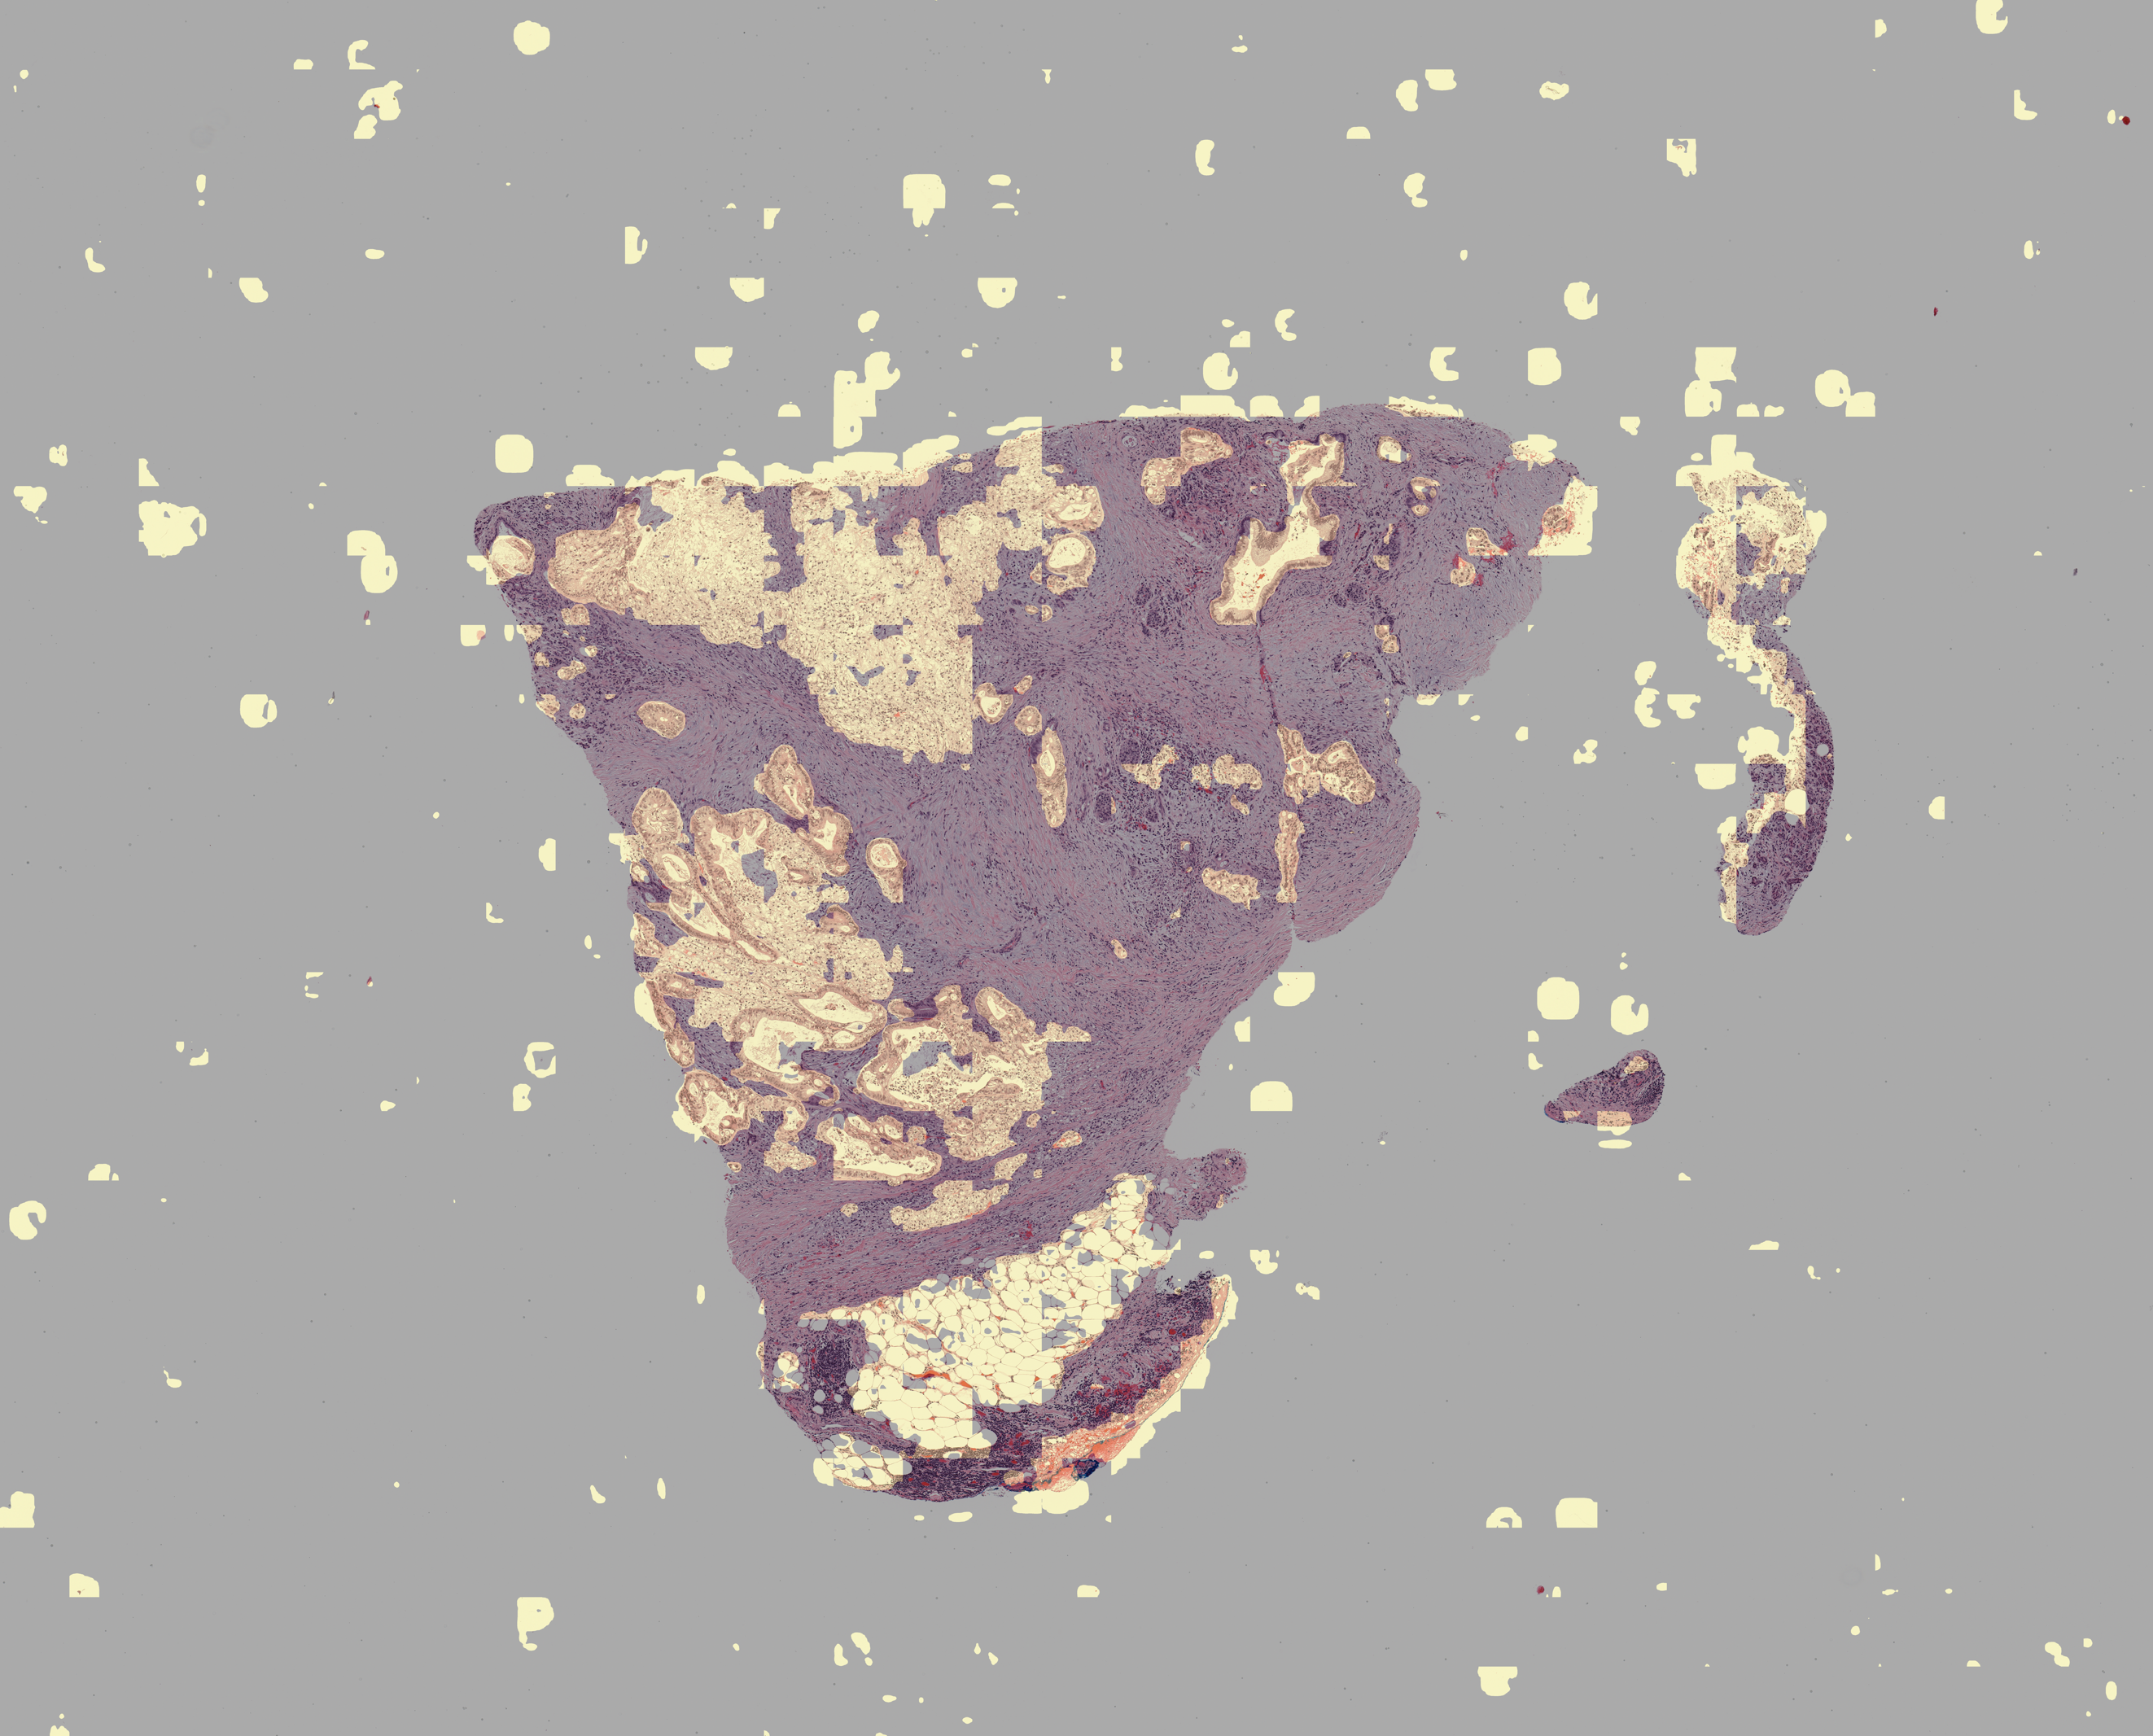

In [31]:
test_merge_image